In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf

import PIL
import PIL.Image
import tensorflow_datasets as tfds
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt

print(tf.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         files.append(os.path.join(dirname, filename))
import pathlib
data_dir = pathlib.Path('/kaggle/input/brain-tumor-classification-mri/Training/').with_suffix('')
testing_data_dir = pathlib.Path('/kaggle/input/brain-tumor-classification-mri/Testing/').with_suffix('')
print(data_dir)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.11.0
/kaggle/input/brain-tumor-classification-mri/Training


In [2]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2870


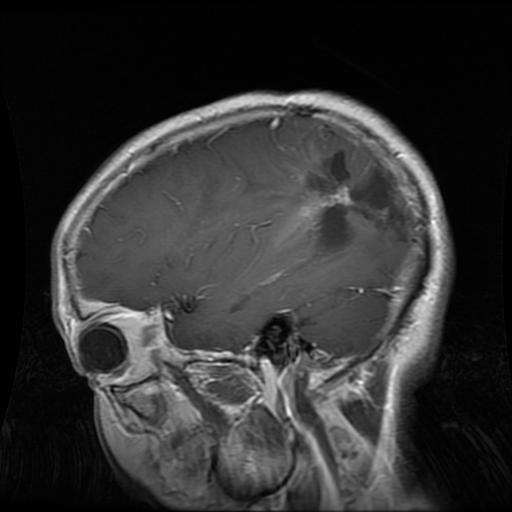

In [3]:
glioma_tumor = list(data_dir.glob('glioma_tumor/*'))
PIL.Image.open(str(glioma_tumor[0]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 394 files belonging to 4 classes.


In [8]:
test_labels = test_ds.class_names
print(test_labels)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [9]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


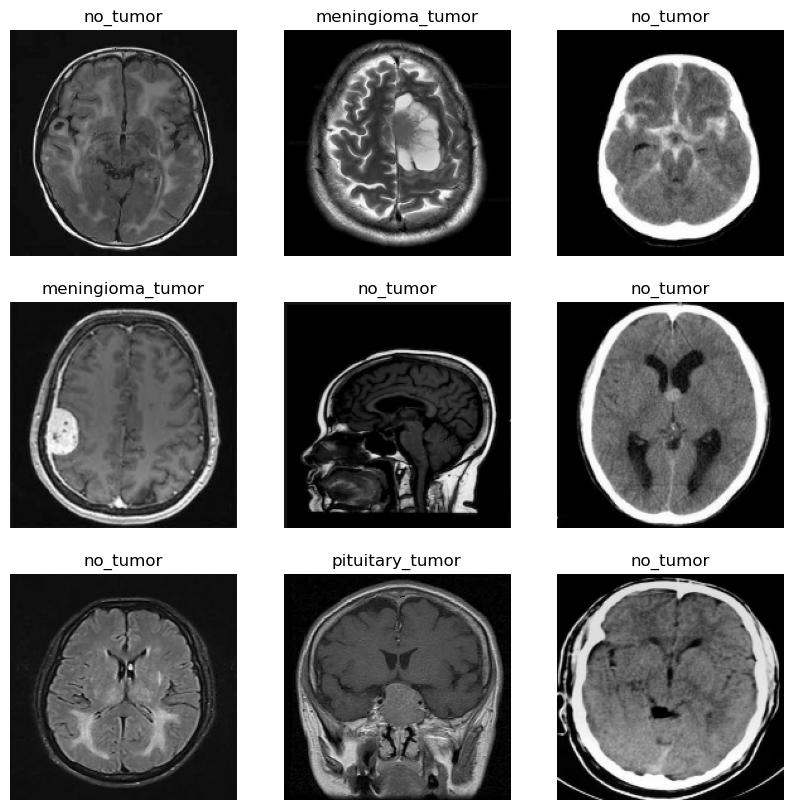

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The **image_batch** shape shows (32, 180, 180, 3) for a batch of 32 images of size 180x180 with three channels (RGB)
The **labels_batch** are the labels for the 32 images

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Normalizes the RGB values to be between 0 and 1 rather than 0 and 255

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

In [14]:
num_classes = 4

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, 'softmax')
])

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights= True, patience=5, verbose=1)
callback = [early_stop]

Optimizing the model using the "adam" optimizer and using "accuracy" metrics

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


Training the model

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=callback
)


Epoch 1/30
72/72 [==============================] - 35s 466ms/step - loss: 2.3258 - accuracy: 0.5096 - val_loss: 0.7906 - val_accuracy: 0.6899
Epoch 2/30
72/72 [==============================] - 32s 440ms/step - loss: 0.5304 - accuracy: 0.7979 - val_loss: 0.5698 - val_accuracy: 0.7805
Epoch 3/30
72/72 [==============================] - 32s 443ms/step - loss: 0.2039 - accuracy: 0.9408 - val_loss: 0.4689 - val_accuracy: 0.8397
Epoch 4/30
72/72 [==============================] - 32s 444ms/step - loss: 0.0927 - accuracy: 0.9808 - val_loss: 0.5053 - val_accuracy: 0.8206
Epoch 5/30
72/72 [==============================] - 32s 446ms/step - loss: 0.0559 - accuracy: 0.9861 - val_loss: 0.5532 - val_accuracy: 0.8345
Epoch 6/30
72/72 [==============================] - 32s 445ms/step - loss: 0.0351 - accuracy: 0.9935 - val_loss: 1.0943 - val_accuracy: 0.6916
Epoch 7/30
72/72 [==============================] - 32s 445ms/step - loss: 0.0484 - accuracy: 0.9852 - val_loss: 0.5896 - val_accuracy: 0.8206

In [17]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
model.save('/kaggle/working/');
print('\nTest accuracy:', test_acc)

13/13 - 2s - loss: 1.7087 - accuracy: 0.7208 - 2s/epoch - 118ms/step

Test accuracy: 0.720812201499939
